# MUSIC PROCESSOING ANALYSIS WITH CHITRALI SITAR (chapter 8)

## Introduction

It has 1 main string and multiple Drone strings. The main string is fretted but not the drone strings. The drone strings are usually strummed open. The drone strings provide a harmonic affect to the melody string.


Sargham Notation:

Seven Notes (swara) & 12 Pitches (shruti)

sa, re, ga, ma, pa, dha, ni




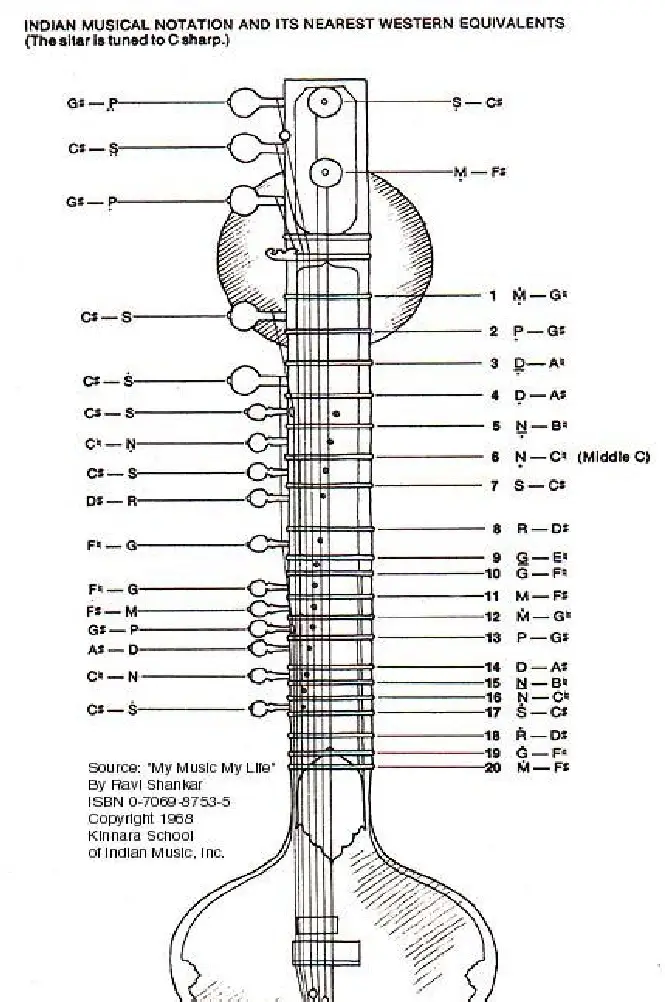

In [7]:
from IPython.display import Image

Image("img/sitar.jpg")

In [2]:
import IPython.display as ipd
import librosa
# import soundfile as sf

music, fs = librosa.load("audio_files/sitar_notes.wav")

ipd.display(ipd.Audio(music, rate=fs))

## Notes Seperation with  Standard Chroma

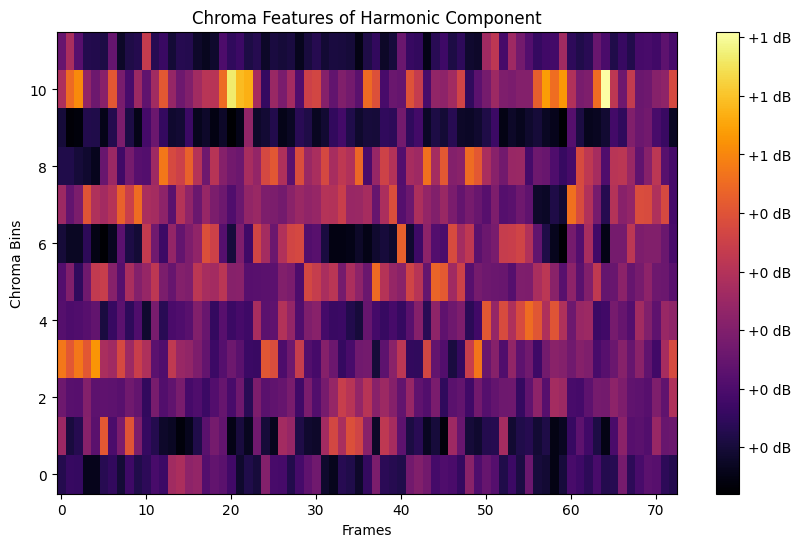

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import librosa


def simple_chroma(x, N, H, Fs):
    # x:       input signal
    # N:       frame length
    # H:       hopsize
    # Fs:      sampling rate

    # Compute the STFT
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant')
    Y = np.abs(X) ** 2
    Y_comp = np.log(1 + 0.5 * Y)

    # Initialize the chroma matrix
    C = np.zeros((12, Y.shape[1]), dtype=Y.dtype)

    # Compute pitch-to-chroma mapping
    n = np.arange(1, Y.shape[0])  # Frequency bin indices
    pitches = np.round(12 * np.log2((Fs * n / N) / 440)) + 69  # Convert to MIDI note numbers
    chroma_mapping = pitches % 12
    chroma_mapping = np.insert(chroma_mapping, 0, -1)  # Ignore DC offset

    # Aggregate energy into chroma bins
    for k in range(12):
        C[k, :] = Y_comp[chroma_mapping == k, :].sum(axis=0)
    
    # Normalize chroma features
    C = normalize_chroma(C, 2, 0.0001)

    return C

def normalize_chroma(C, norm_p, threshold):
    f_norm = norm(C, norm_p, axis=0)
    C_norm = C.copy()
    C_norm[:, f_norm >= threshold] /= f_norm[f_norm >= threshold]
    return C_norm

file_path = "audio_files/sitar_noisy3.wav"
x, Fs = librosa.load(file_path, sr=None)

N = 4410//3
H = 2205*3
w = "hann"

C_h = simple_chroma(x, N, H, Fs)

plt.figure(figsize=(10, 6))
plt.imshow(C_h, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title("Chroma Features of Harmonic Component")
plt.xlabel("Frames")
plt.ylabel("Chroma Bins")
plt.show()

## Harmnoic Percussive Sound Seperation

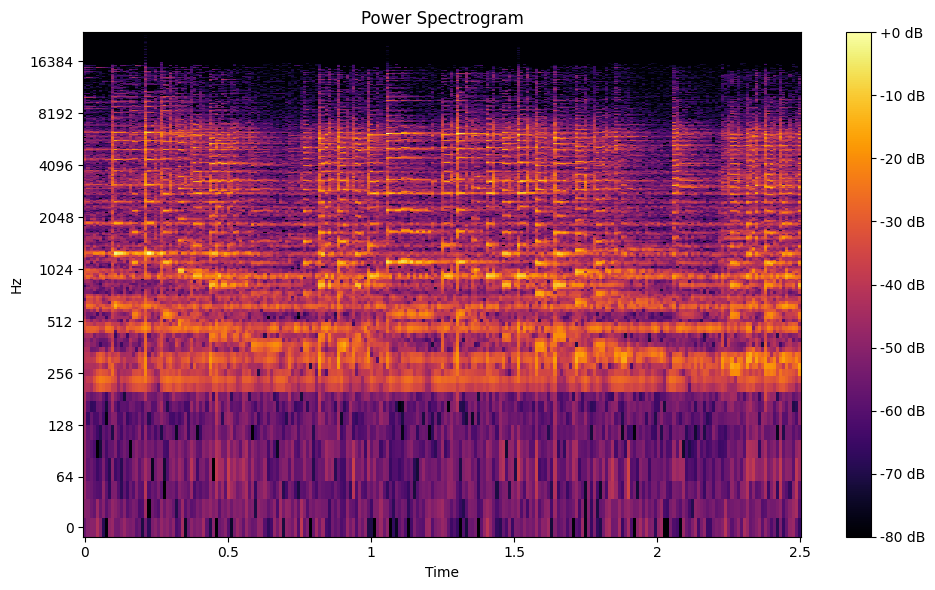

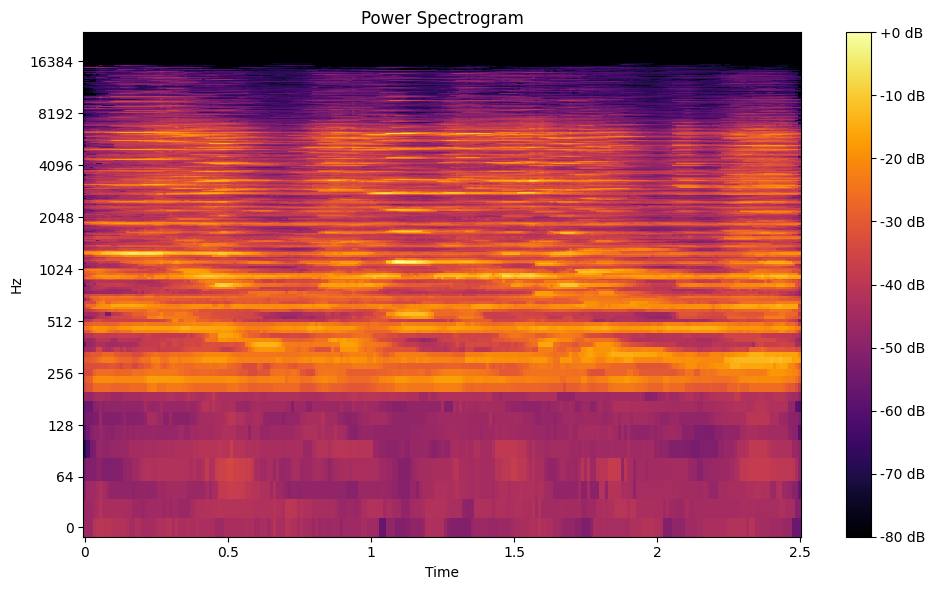

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal




# Load the WAV file
filename = "audio_files/sitar_noisy3.wav"  # Replace with your file path
y, sr = librosa.load(filename, sr=None)

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y,hop_length=4096//2)

# Compute the power spectrogram (magnitude squared)
Y = np.abs(D)**2

# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()

def horizontal_median_filter(B, size):
    return np.apply_along_axis(lambda m: signal.medfilt(m, size), axis=1, arr=B)

def vertical_median_filter(B, size):
    return np.apply_along_axis(lambda m: signal.medfilt(m, size), axis=0, arr=B)
    
def apply_median_filter(Y, h_size, p_size):
    harmonic_spectrogram = horizontal_median_filter(Y, h_size)
    percusive_spectogram = vertical_median_filter(Y, p_size)
    
    return harmonic_spectrogram, percusive_spectogram

Y_h, Y_p = apply_median_filter(Y, h_size=11, p_size=11)

# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y_h, ref=np.max)
# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()


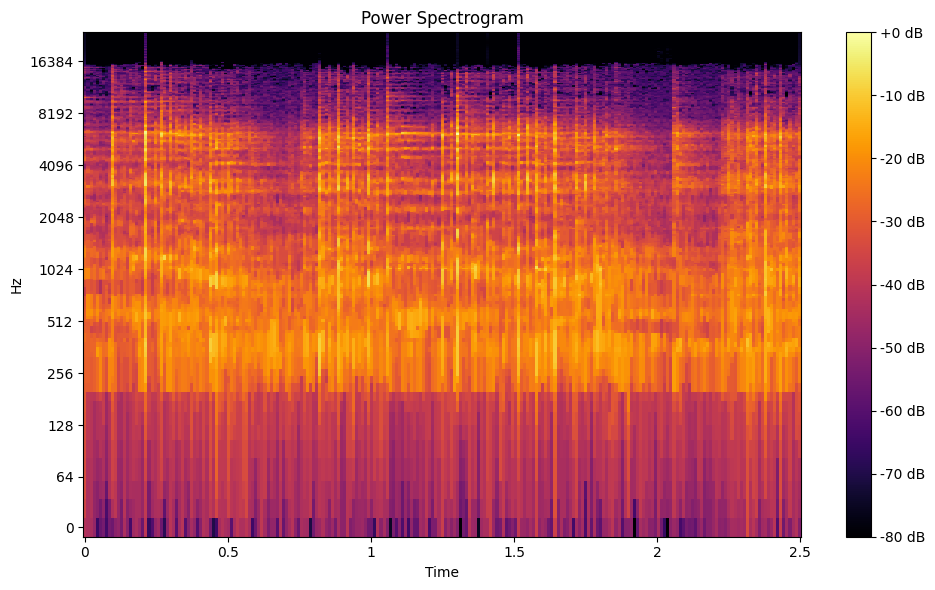

In [3]:


# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y_p, ref=np.max)
# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()


In [1]:
import soundfile as sf



def convert_to_indices(lh_sec, lp_Hz, Fs, N, H):
    L_h = int(np.ceil(Fs * lh_sec / H))
    L_d = int(np.ceil(N * lp_Hz / Fs))
    return L_h if not L_h % 2 == 0 else L_h + 1, L_d if not L_d % 2 == 0 else L_d + 1

def apply_median_filter(Y, h_size, p_size):
    harmonic_spectrogram = horizontal_median_filter(Y, h_size)
    percusive_spectogram = vertical_median_filter(Y, p_size)
    
    return harmonic_spectrogram, percusive_spectogram


def binary_mask(Y_h, Y_p):
    mask_h = Y_h >= Y_p
    return mask_h, ~mask_h

    
def HPSS(x, N, H, w, Fs, lh_sec, lp_Hz):
    # x:      Input signal
    # N:      Frame length
    # H:      Hopsize
    # w:      Window function of length N
    # Fs:     Sampling rate of x
    # lh_sec: Horizontal median filter length given in seconds
    # lp_Hz:  Percussive median filter length given in Hertz

    # stft
    X = librosa.stft(x, hop_length=H, n_fft=N, window=w)

    # power spectrogram
    Y = np.abs(X) ** 2

    # median filtering
    L_h, L_p = convert_to_indices(lh_sec, lp_Hz, Fs, N, H)
    print(L_h, L_p)
    Y_h, Y_p = apply_median_filter(Y, *convert_to_indices(lh_sec, lp_Hz, Fs, N, H))

    # masking
    M_h, M_p = binary_mask(Y_h, Y_p)
    X_h, X_p = X * M_h, X * M_p
    
    # istft
    x_h, x_p = librosa.istft(X_h), librosa.istft(X_p)
    
    return x_h, x_p




x, Fs = sf.read("audio_files/sitar_notes.wav")
x_h, x_p = HPSS(x, 1024, 512, "hann", Fs, 0.2, 500)

print('Orignal')
display(Audio(x, rate=Fs))
print('Harmonic Component')
display(Audio(x_h, rate=Fs))
print('Percussive Component')
display(Audio(x_p, rate=Fs))

NameError: name 'librosa' is not defined

## Melody Extraction

### F0 Estimation

(0.0, 18.004172335600906)

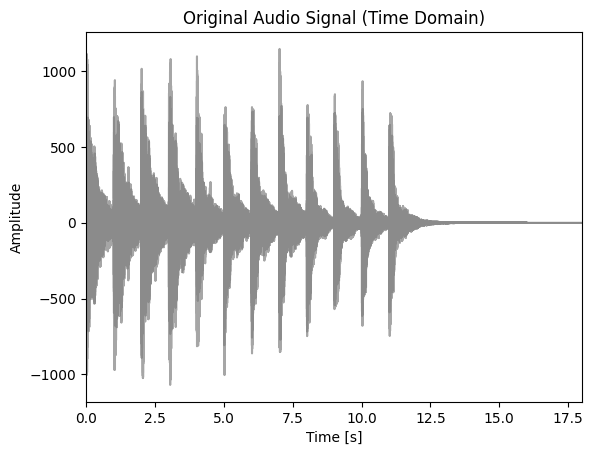

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import find_peaks

def autocorrelation(x):
    """Compute autocorrelation of signal x."""
    x = x - np.mean(x)  # Remove DC component
    corr = np.correlate(x, x, mode='full')
    return corr[len(corr)//2:]  # Return non-negative lags

def estimate_f0(signal, fs, frame_size=1024, hop_size=512):
    """Estimate f0 using autocorrelation method and track the frequency."""
    num_frames = (len(signal) - frame_size) // hop_size
    f0_values = []

    for i in range(num_frames):
        start_idx = i * hop_size
        end_idx = start_idx + frame_size
        frame = signal[start_idx:end_idx]
        
        # Calculate autocorrelation
        corr = autocorrelation(frame)
        
        # Find the first peak (excluding lag 0)
        peaks, _ = find_peaks(corr[1:])  # Find peaks starting from index 1 (ignore lag=0)
        
        if len(peaks) > 0:
            # The lag corresponding to the fundamental frequency
            fundamental_period = peaks[0] + 1  # Add 1 to account for the 1-indexing in find_peaks
            f0 = fs / fundamental_period
        else:
            f0 = 0  # If no peak found, assume silence or unidentifiable pitch
        
        f0_values.append(f0)
    
    return f0_values

def plot_f0(f0_values, fs, hop_size):
    """Plot the estimated f0 over time."""
    time = np.arange(0, len(f0_values) * hop_size, hop_size) / fs
    plt.plot(time, f0_values, label="Estimated f0")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Fundamental Frequency Estimation")
    plt.show()

# Load WAV file
filename = 'audio_files/sitar_notes.wav'  # Replace with your file path
fs, x = wav.read(filename)



# Plot the original signal
plt.plot(signal_time, x, label="Original Signal", color='gray', alpha=0.7)
plt.title("Original Audio Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, len(x) / fs)


In [ ]:

import numpy as np
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def f0_to_midi(f0):
    """Convert fundamental frequency (f0) to MIDI note number."""
    if f0 > 0:  # Ignore zero or non-pitched frequencies
        midi_note = 69 + 12 * np.log2(f0 / 440.0)
        return int(round(midi_note))  # Round to nearest integer
    else:
        return None  # No valid note for f0 <= 0

def f0_to_note_name(midi_note):
    """Convert MIDI note number to note name."""
    # List of note names in one octave
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1  # MIDI notes start from C-1, so subtract 1 for octave
    note = note_names[midi_note % 12]
    return f"{note}{octave}"

def extract_notes_from_f0(f0_values):
    """Extract musical notes from the fundamental frequency (f0) values."""
    notes = []
    midi_notes = []
    for f0 in f0_values:
        midi_note = f0_to_midi(f0)
        if midi_note is not None:
            note_name = f0_to_note_name(midi_note)
            notes.append(note_name)
            midi_notes.append(midi_note)
        else:
            notes.append(None)  # No valid note for f0 <= 0
    return notes, midi_notes



# Assuming f0_values are already obtained from previous estimation
f0_values = estimate_f0(x, fs)
# Time values for the signal and f0 values

hop_size=512
signal_time = np.arange(0, len(x)) / fs
f0_time = np.arange(0, num_frames) * hop_size / fs


notes, midi_notes = extract_notes_from_f0(f0_values)


# Optionally, plot the extracted notes
plt.plot(f0_values, label="Estimated f0 (Hz)", color='blue')
plt.title("Estimated f0 and Extracted Notes")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()


In [7]:

import numpy as np
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mido import Message, MidiFile, MidiTrack

def f0_to_midi(f0):
    """Convert fundamental frequency (f0) to MIDI note number."""
    if f0 > 0:  # Ignore zero or non-pitched frequencies
        midi_note = 69 + 12 * np.log2(f0 / 440.0)
        return int(round(midi_note))  # Round to nearest integer
    else:
        return None  # No valid note for f0 <= 0

def f0_to_note_name(midi_note):
    """Convert MIDI note number to note name."""
    # List of note names in one octave
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_note // 12) - 1  # MIDI notes start from C-1, so subtract 1 for octave
    note = note_names[midi_note % 12]
    return f"{note}{octave}"

def extract_notes_from_f0(f0_values, fs, hop_size):
    """Extract musical notes and their durations from the fundamental frequency (f0) values."""
    notes = []
    durations = []
    
    prev_note = None
    start_time = 0  # Track when a note starts
    for i, f0 in enumerate(f0_values):
        midi_note = f0_to_midi(f0)
        current_time = i * hop_size / fs  # Current time in seconds
        
        if midi_note is not None:
            # If the note has changed or it's a new note
            if midi_note != prev_note:
                if prev_note is not None:
                    # Store the previous note and its duration
                    note_duration = current_time - start_time
                    notes.append((prev_note, start_time, note_duration))
                # Update with new note
                prev_note = midi_note
                start_time = current_time
        
        else:
            # Handle case where there's no valid note (f0 <= 0)
            if prev_note is not None:
                note_duration = current_time - start_time
                notes.append((prev_note, start_time, note_duration))
                prev_note = None
    
    # For the last note
    if prev_note is not None:
        note_duration = current_time - start_time
        notes.append((prev_note, start_time, note_duration))
    
    return notes

def create_midi(notes, midi_filename):
    """Create a MIDI file from the extracted notes and their durations."""
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)

    # Set the tempo (500000 microseconds per beat, ~120 bpm)
    track.append(Message('program_change', program=12))  # Acoustic Grand Piano
    for note, start_time, duration in notes:
        start_ticks = int(start_time * 480)  # Convert time to ticks (480 ticks per beat)
        duration_ticks = int(duration * 480)
        
        # Add note-on and note-off messages
        track.append(Message('note_on', note=note, velocity=64, time=start_ticks))
        track.append(Message('note_off', note=note, velocity=64, time=duration_ticks))
    
    # Save the MIDI file
    midi.save(midi_filename)

# Load the sitar WAV file
filename = 'audio_files/sitar_noisy3.wav'  # Replace with your file path
fs, signal = wav.read(filename)

# Convert stereo to mono if needed
if len(signal.shape) > 1:
    signal = np.mean(signal, axis=1)

# Estimate f0 and track it
f0_values = estimate_f0(signal, fs)

# Extract notes and their durations
notes = extract_notes_from_f0(f0_values, fs, hop_size=512)

# Print the extracted notes and durations
for note, start_time, duration in notes:
    note_name = f0_to_note_name(note)
    print(f"Note: {note_name}, Start time: {start_time:.2f}s, Duration: {duration:.2f}s")

# Create the MIDI file from the extracted notes
# create_midi(notes, "output_sitar_notes.mid")


/tmp/ipykernel_24665/1754450656.py:80: WavFileWarning: Reached EOF prematurely; finished at 1920079 bytes, expected 4294967303 bytes from header.
  fs, signal = wav.read(filename)


Note: E8, Start time: 0.00s, Duration: 0.01s
Note: C7, Start time: 0.01s, Duration: 0.02s
Note: A7, Start time: 0.03s, Duration: 0.01s
Note: C#7, Start time: 0.04s, Duration: 0.02s
Note: G#6, Start time: 0.06s, Duration: 0.01s
Note: C#7, Start time: 0.07s, Duration: 0.01s
Note: D7, Start time: 0.09s, Duration: 0.01s
Note: D#6, Start time: 0.10s, Duration: 0.03s
Note: F6, Start time: 0.13s, Duration: 0.01s
Note: G6, Start time: 0.14s, Duration: 0.02s
Note: F#6, Start time: 0.16s, Duration: 0.01s
Note: D#6, Start time: 0.17s, Duration: 0.04s
Note: G6, Start time: 0.21s, Duration: 0.02s
Note: D#6, Start time: 0.23s, Duration: 0.03s
Note: F#6, Start time: 0.27s, Duration: 0.01s
Note: G6, Start time: 0.28s, Duration: 0.01s
Note: F#8, Start time: 0.29s, Duration: 0.01s
Note: A5, Start time: 0.30s, Duration: 0.01s
Note: G6, Start time: 0.31s, Duration: 0.01s
Note: D7, Start time: 0.32s, Duration: 0.01s
Note: C#7, Start time: 0.33s, Duration: 0.01s
Note: C#6, Start time: 0.34s, Duration: 0.01s

### Fundemental Frequeny Tracking


In [ ]:
import numpy as np
import os, sys, librosa
# import pandas as pd
from scipy import signal
from scipy import linalg
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import IPython.display as ipd
from numba import jit

import libfmp
import libfmp.c8

## Saliance Based Frequency Trajectory
def sonify_trajectory_with_sinusoid(traj, audio_len, Fs=22050, amplitude=0.3, smooth_len=11):
    """Sonification of trajectory with sinusoidal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        traj (np.ndarray): F0 trajectory (time in seconds, frequency in Hz)
        audio_len (int): Desired audio length in samples
        Fs (scalar): Sampling rate (Default value = 22050)
        amplitude (float): Amplitude (Default value = 0.3)
        smooth_len (int): Length of amplitude smoothing filter (Default value = 11)

    Returns:
        x_soni (np.ndarray): Sonification
    """
    # unit confidence if not specified
    if traj.shape[1] < 3:
        confidence = np.zeros(traj.shape[0])
        confidence[traj[:, 1] > 0] = amplitude
    else:
        confidence = traj[:, 2]

    # initialize
    x_soni = np.zeros(audio_len)
    amplitude_mod = np.zeros(audio_len)

    # Computation of hop size
    # sine_len = int(2 ** np.round(np.log(traj[1, 0]*Fs) / np.log(2)))
    sine_len = int(traj[1, 0] * Fs)

    t = np.arange(0, sine_len) / Fs
    phase = 0

    # loop over all F0 values, insure continuous phase
    for idx in np.arange(0, traj.shape[0]):
        cur_f = traj[idx, 1]
        cur_amp = confidence[idx]

        if cur_f == 0:
            phase = 0
            continue

        cur_soni = np.sin(2*np.pi*(cur_f*t+phase))
        diff = np.maximum(0, (idx+1)*sine_len - len(x_soni))
        if diff > 0:
            x_soni[idx * sine_len:(idx + 1) * sine_len - diff] = cur_soni[:-diff]
            amplitude_mod[idx * sine_len:(idx + 1) * sine_len - diff] = cur_amp
        else:
            x_soni[idx*sine_len:(idx+1)*sine_len-diff] = cur_soni
            amplitude_mod[idx*sine_len:(idx+1)*sine_len-diff] = cur_amp

        phase += cur_f * sine_len / Fs
        phase -= 2 * np.round(phase/2)

    # filter amplitudes to avoid transients
    amplitude_mod = np.convolve(amplitude_mod, np.hanning(smooth_len)/np.sum(np.hanning(smooth_len)), 'same')
    x_soni = x_soni * amplitude_mod
    return x_soni



def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F



def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent
def visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=55.0, colorbar=True, cmap='gray_r',
                                        figsize=(7, 4), traj=None, constraint_region=None, ax=None):
    """Visualize salience representation with optional F0-trajectory and constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T_coef: Time axis
        F_coef_cents: Frequency axis in cents
        F_ref: Reference frequency (Default value = 55.0)
        colorbar: Show or hide colorbar (Default value = True)
        cmap: Color map (Default value = 'gray_r')
        figsize: Figure size (Default value = (7, 4))
        traj: F0 trajectory (time in seconds, frequency in Hz) (Default value = None)
        constraint_region: Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        ax: Handle to existing axis (Default value = None)

    Returns:
        fig: Handle to figure
        ax: Handle to cent axis
        ax_f: Handle to frequency axis
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    sal = ax.imshow(Z, extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]],
                    cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')

    y_ticklabels_left = np.arange(F_coef_cents[0], F_coef_cents[-1]+1, 1200)
    ax.set_yticks(y_ticklabels_left)
    ax.set_yticklabels(y_ticklabels_left)
    ax.set_ylabel('Frequency (Cents)')

    if colorbar:
        plt.colorbar(sal, ax=ax, pad=0.1)

    ax_f = ax.twinx()  # instantiate a second axes that shares the same y-axis
    ax_f.set_yticks(y_ticklabels_left - F_coef_cents[0])
    y_ticklabels_right = cents_to_hz(y_ticklabels_left, F_ref).astype(int)
    ax_f.set_yticklabels(y_ticklabels_right)
    ax_f.set_ylabel('Frequency (Hz)')

    # plot contour
    if traj is not None:
        traj_plot = traj[traj[:, 1] > 0, :]
        traj_plot[:, 1] = hz_to_cents(traj_plot[:, 1], F_ref)
        ax.plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')

    # plot constraint regions
    if constraint_region is not None:
        for row in constraint_region:
            t_start = row[0]  # sec
            t_end = row[1]  # sec
            f_start = row[2]  # Hz
            f_end = row[3]  # Hz
            ax.add_patch(matplotlib.patches.Rectangle((
                t_start, hz_to_cents(f_start, F_ref)), width=t_end-t_start,
                height=hz_to_cents(f_end, F_ref)-hz_to_cents(f_start, F_ref),
                fill=False, edgecolor='k', linewidth=3, zorder=2))

    ax.set_xlabel('Time (seconds)')

    if fig is not None:
        plt.tight_layout()

    return fig, ax, ax_f



x, Fs = librosa.load("audio_files/sitar_notes.wav", sr=None)
x_duration = len(x)/Fs

# Computation of salience representation
N = 1024
H = 128
R = 10
F_min = 55.0
F_max = 1760.0
num_harm = 8
freq_smooth_len = 11
alpha = 0.9
gamma = 0.1

Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(x, Fs, N=N, H=H, R=R, 
                    F_min=F_min, F_max=F_max, num_harm=num_harm, 
                    freq_smooth_len=freq_smooth_len, alpha=alpha, gamma=gamma)
T_coef = (np.arange(Z.shape[1]) * H) / Fs

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, ax=None)
plt.show()
# Frequency trajectory via maximization
index_max = np.argmax(Z, axis=0)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_max].reshape(-1, 1)))

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=5)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))
## Continuity Constraints
# @jit(nopython=True)
def define_transition_matrix(B, tol=0, score_low=0.01, score_high=1.0):
    """Generate transition matrix

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        B (int): Number of bins
        tol (int): Tolerance parameter for transition matrix (Default value = 0)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        T (np.ndarray): Transition matrix
    """
    col = np.ones((B,)) * score_low
    col[0:tol+1] = np.ones((tol+1, )) * score_high
    T = linalg.toeplitz(col)
    return T

# Compute transition matrix
T = define_transition_matrix(B=51, tol=5)

# Plot
colorList = np.array([[1,0.9,0.9,1],[0,0,0,1]])
cmap = ListedColormap(colorList) 
plt.figure(figsize=(4,3))
im = plt.imshow(T, origin='lower', cmap=cmap)
plt.title('Transition matrix')
plt.xlabel('Bin index')
plt.ylabel('Bin index')
ax_cb = plt.colorbar(im)
ax_cb.set_ticks(np.array([0.25, 0.75]))
ax_cb.set_ticklabels(np.array([np.min(T), np.max(T)])) 
@jit(nopython=True)
def compute_trajectory_dp(Z, T):
    """Trajectory tracking using dynamic programming

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T: Transisition matrix

    Returns:
        eta_DP (np.ndarray): Trajectory indices
    """
    B, N = Z.shape
    eps_machine = np.finfo(np.float32).eps
    Z_log = np.log(Z + eps_machine)
    T_log = np.log(T + eps_machine)

    E = np.zeros((B, N))
    D = np.zeros((B, N))
    D[:, 0] = Z_log[:, 0]

    for n in np.arange(1, N):
        for b in np.arange(0, B):
            D[b, n] = np.max(T_log[b, :] + D[:, n-1]) + Z_log[b, n]
            E[b, n-1] = np.argmax(T_log[b, :] + D[:, n-1])

    # backtracking
    eta_DP = np.zeros(N)
    eta_DP[N-1] = int(np.argmax(D[:, N-1]))

    for n in np.arange(N-2, -1, -1):
        eta_DP[n] = E[int(eta_DP[n+1]), n]

    return eta_DP.astype(np.int64)

# Frequency trajectory via DP-based optimization
B, N = Z.shape
T = define_transition_matrix(B, tol=5)
index_DP =  compute_trajectory_dp(Z, T)

traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_DP].reshape(-1, 1)))

# Visualization
figsize = (10,3)
cmap = libfmp.b.compressed_gray_cmap(alpha=10)
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, 
                                    figsize=figsize, cmap=cmap, 
                                    colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))
## Score-Informed Constraints

def convert_ann_to_constraint_region(ann, tol_freq_cents=300.0):
    """Convert score annotations to constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        ann (list): Score annotations [[start_time, end_time, MIDI_pitch], ...
        tol_freq_cents (float): Tolerance in pitch directions specified in cents (Default value = 300.0)

    Returns:
        constraint_region (np.ndarray): Constraint regions
    """
    tol_pitch = tol_freq_cents / 100
    freq_lower = 2 ** ((ann[:, 2] - tol_pitch - 69)/12) * 440
    freq_upper = 2 ** ((ann[:, 2] + tol_pitch - 69)/12) * 440
    constraint_region = np.concatenate((ann[:, 0:2],
                                        freq_lower.reshape(-1, 1),
                                        freq_upper.reshape(-1, 1)), axis=1)
    return constraint_region

# @jit(nopython=True)
def compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region=None,
                          tol=5, score_low=0.01, score_high=1.0):
    """Trajectory tracking with constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end_hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        eta (np.ndarray): Trajectory indices, unvoiced frames are indicated with -1
    """
    # do tracking within every constraint region
    if constraint_region is not None:
        # initialize contour, unvoiced frames are indicated with -1
        eta = np.full(len(T_coef), -1)

        for row_idx in range(constraint_region.shape[0]):
            t_start = constraint_region[row_idx, 0]  # sec
            t_end = constraint_region[row_idx, 1]  # sec
            f_start = constraint_region[row_idx, 2]  # Hz
            f_end = constraint_region[row_idx, 3]  # Hz

            # convert start/end values to indices
            t_start_idx = np.argmin(np.abs(T_coef - t_start))
            t_end_idx = np.argmin(np.abs(T_coef - t_end))
            f_start_idx = np.argmin(np.abs(F_coef_hertz - f_start))
            f_end_idx = np.argmin(np.abs(F_coef_hertz - f_end))

            # track in salience part
            cur_Z = Z[f_start_idx:f_end_idx+1, t_start_idx:t_end_idx+1]
            T = define_transition_matrix(cur_Z.shape[0], tol=tol,
                                         score_low=score_low, score_high=score_high)
            cur_eta = compute_trajectory_dp(cur_Z, T)

            # fill contour
            eta[t_start_idx:t_end_idx+1] = f_start_idx + cur_eta
    else:
        T = define_transition_matrix(Z.shape[0], tol=tol, score_low=score_low, score_high=score_high)
        eta = compute_trajectory_dp(Z, T)

    return eta

# Read score annotations and convert to constraint regions
ann_score_df = libfmp.b.read_csv("sitar_midi_data.csv")
print('Score annotations:')
ipd.display(ipd.HTML(ann_score_df.to_html()))
ann_score = ann_score_df.values
constraint_region = convert_ann_to_constraint_region(ann_score, tol_freq_cents=300)
print('Constraint regions:')
print(constraint_region)

# Frequency trajectory using constraint regions
index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region, tol=5)
traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
traj[index_CR==-1, 1] = 0  # set unvoiced frames to zero

# Visualization
visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=F_min, figsize=figsize, cmap=cmap, 
                                    constraint_region=constraint_region, colorbar=True, traj=traj, ax=None)
plt.show()

# Sonification
x_traj_mono = sonify_trajectory_with_sinusoid(traj, len(x), Fs, smooth_len=11)
x_traj_stereo = np.vstack((x.reshape(1,-1), x_traj_mono.reshape(1,-1)))  
print('F0 sonification (right channel), original recording (left channel)')
ipd.display(ipd.Audio(x_traj_stereo, rate=Fs))

## Non-Negative Matrix Factorization

In [3]:
import os, sys
import numpy as np
import scipy
#import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
#from matplotlib import gridspec
from numba import jit
from IPython.display import Audio

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

@jit(nopython=True)
def nmf(V, R, thresh=0.001, L=1000, W=None, H=None, norm=False, report=False):
    """NMF algorithm with Euclidean distance

    Notebook: C8/C8S3_NMFbasic.ipynb

    Args:
        V (np.ndarray): Nonnegative matrix of size K x N
        R (int): Rank parameter
        thresh (float): Threshold used as stop criterion (Default value = 0.001)
        L (int): Maximal number of iteration (Default value = 1000)
        W (np.ndarray): Nonnegative matrix of size K x R used for initialization (Default value = None)
        H (np.ndarray): Nonnegative matrix of size R x N used for initialization (Default value = None)
        norm (bool): Applies max-normalization of columns of final W (Default value = False)
        report (bool): Reports errors during runtime (Default value = False)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R
        H (np.ndarray): Nonnegative matrix of size R x N
        V_approx (np.ndarray): Nonnegative matrix W*H of size K x N
        V_approx_err (float): Error between V and V_approx
        H_W_error (np.ndarray): History of errors of subsequent H and W matrices
    """
    K = V.shape[0]
    N = V.shape[1]
    if W is None:
        W = np.random.rand(K, R)
    if H is None:
        H = np.random.rand(R, N)
    V = V.astype(np.float64)
    W = W.astype(np.float64)
    H = H.astype(np.float64)
    H_W_error = np.zeros((2, L))
    ell = 1
    below_thresh = False
    eps_machine = np.finfo(np.float32).eps
    while not below_thresh and ell <= L:
        H_ell = H
        W_ell = W
        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

        H_error = np.linalg.norm(H-H_ell, ord=2)
        W_error = np.linalg.norm(W - W_ell, ord=2)
        H_W_error[:, ell-1] = [H_error, W_error]
        if report:
            print('Iteration: ', ell, ', H_error: ', H_error, ', W_error: ', W_error)
        if H_error < thresh and W_error < thresh:
            below_thresh = True
            H_W_error = H_W_error[:, 0:ell]
        ell += 1
    if norm:
        for r in range(R):
            v_max = np.max(W[:, r])
            if v_max > 0:
                W[:, r] = W[:, r] / v_max
                H[r, :] = H[r, :] * v_max
    V_approx = W.dot(H)
    V_approx_err = np.linalg.norm(V-V_approx, ord=2)
    return W, H, V_approx, V_approx_err, H_W_error

In [4]:
 def plot_nmf(V, W, H, V_approx, error, figsize=(10,2), aspect='auto', wr=[1, 0.5, 1, 1]): 
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': wr},
                           figsize=figsize)    
    cmap = 'gray_r'
    # im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V)])
    im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap)
    ax[0].set_title(r'$V$')
    plt.sca(ax[0])
    plt.colorbar(im)   
    im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(W)])
    ax[1].set_title(r'$W$')
    plt.sca(ax[1])
    plt.colorbar(im)
    im = ax[2].imshow(H, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(H)])
    ax[2].set_title(r'$H$')
    plt.sca(ax[2])    
    plt.colorbar(im)
    im = ax[3].imshow(V_approx, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V_approx)])
    ax[3].set_title(r'$WH$ (error = %0.2f)'%error)
    plt.sca(ax[3])    
    plt.colorbar(im)
    plt.tight_layout() 
    plt.show() 


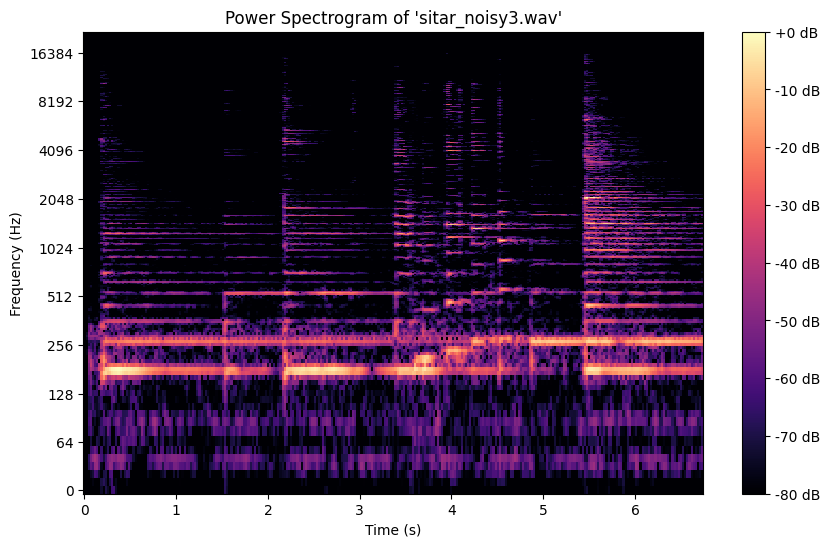

In [15]:
sitar_path = "audio_files/sitar4_1.wav"
piano_path = "audio_files/music_notes.wav"

x, Fs = librosa.load(sitar_path, sr=None)
# x, Fs = librosa.load(piano_path, sr=None)
# Audio(x, rate=Fs)
N = 2048 * 2
H = N // 4
hop = H
n_fft = N
# x_h, x_p = HPSS(x, 1024, 512, "hann", Fs, 0.2, 500)


X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant')
Y = np.abs(X) ** 2

plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(Y, ref=np.max),
                         sr=Fs, hop_length=H, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Power Spectrogram of 'sitar_noisy3.wav'")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [8]:
x_h, x_p = HPSS(x, N, H, "hann", Fs, 0.2, 500)

9 47


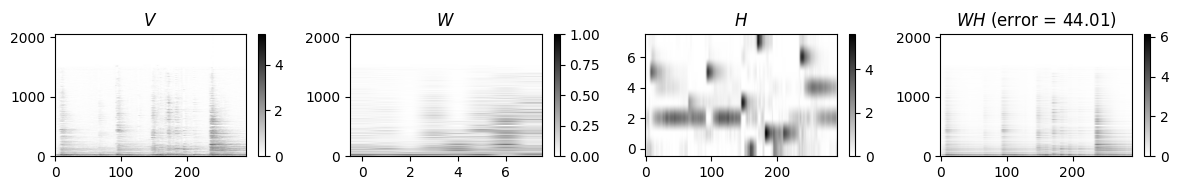

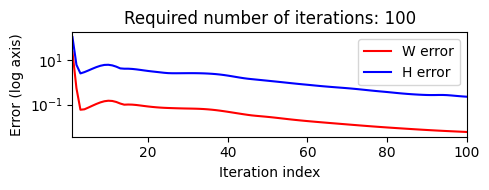

In [12]:
V = np.log(1 + np.abs(X))
K = V.shape[0]
N = V.shape[1]
R = 8
thresh = 0.001
L = 100

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N) 

V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                   L=L, W=W_init, H=H_init, norm=1, report=0)

plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
         aspect='auto', wr=[1, 1, 1, 1])

plt.figure(figsize=(5,2))
num_iter = H_W_error.shape[1]
plt.plot(np.arange(num_iter)+1, H_W_error[0,:], 'r', label='W error')
plt.plot(np.arange(num_iter)+1, H_W_error[1,:], 'b', label='H error')
plt.yscale('log')
plt.xlabel('Iteration index')
plt.ylabel('Error (log axis)')
plt.title('Required number of iterations: %d'%num_iter)
plt.xlim([1, num_iter])
plt.legend()
plt.tight_layout()

In [13]:
# post processing

threshold = 0.01 * np.max(H)
note_activations = H > threshold  # Binary thresholding for note onset detection

# Example: Map frequency bins in W to musical pitches
frequencies = librosa.fft_frequencies(sr=Fs, n_fft=n_fft)
pitches = librosa.hz_to_midi(frequencies)

# Map the most prominent frequency of each component in W to a pitch
note_pitches = []
for r in range(R):
    dominant_freq_bin = np.argmax(W[:, r])  # Find max frequency bin in the component
    # print(dominant_freq_bin)
    note_pitches.append(pitches[dominant_freq_bin])

print("Detected Notes (MIDI numbers):", note_pitches)


Detected Notes (MIDI numbers): [np.float64(55.740706023014056), np.float64(60.49185013898772), np.float64(60.49185013898772), np.float64(91.39559810723696), np.float64(83.04831933437518), np.float64(52.76557586169102), np.float64(95.96452996793656), np.float64(58.27875528533859)]


C:\Users\Shehryar Tariq\anaconda3\envs\mpa_sitar\Lib\site-packages\librosa\core\convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


In [14]:
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
notes = []

# Convert MIDI numbers to notes
for midi in note_pitches:
    midi_rounded = round(midi)  # Round to nearest integer
    note = note_names[midi_rounded % 12]  # Note name
    octave = (midi_rounded // 12) - 1  # Octave calculation
    notes.append(f"{note}{octave}")

print("Detected Notes:", notes)

Detected Notes: ['G#3', 'C4', 'C4', 'G6', 'B5', 'F3', 'C7', 'A#3']
